In [1]:
# visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumBarunGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) # 폰트 설정
plt.rc('font', family='NanumBarunGothic')
import seaborn as sns

# utils
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import warnings;warnings.filterwarnings('ignore')

# Model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV

import eli5
from eli5.sklearn import PermutationImportance

In [2]:
# 필요한 데이터를 load 하겠습니다. 경로는 환경에 맞게 지정해주면 됩니다.
datafix = '../data/datafix.csv'

concat_select = pd.read_csv(datafix)

## 5. Model Training

- 이제 위에서 만든 파생변수들과 정제한 데이터를 기반으로 본격적으로 부동산 실거래가를 예측하는 모델링을 진행하겠습니다.
- 모델링에는 `sklearn`의 `RandomForest`를 이용하도록 하겠습니다.

- 참고 ✅
  - `RandomForest`는 배깅(Bagging)의 일종으로, 학습시키는 데이터 뿐 아니라 특성변수(X)들도 무작위로 선택해 트리를 생성하는 방법입니다.
  - 모델 학습 과정에서 서로 다른 N개의 Tree 생성하고, N개의 Tree에서 발생한 Output을 Voting(범주형, 분류문제)하거나, Average(연속형, 회귀문제)해 최종 Output 생성합니다.
  - 이는 High variance, Low bias 상황에서 분산(Variance) 감소에 도움을 줍니다.

In [3]:
# 이제 다시 train과 test dataset을 분할해줍니다. 위에서 제작해 놓았던 is_test 칼럼을 이용합니다.
dt_train = concat_select.query('is_test==0')
dt_test = concat_select.query('is_test==1')

# 이제 is_test 칼럼은 drop해줍니다.
dt_train.drop(['is_test'], axis = 1, inplace=True)
dt_test.drop(['is_test'], axis = 1, inplace=True)
print(dt_train.shape, dt_test.shape)

(1029552, 48) (9272, 48)


In [4]:
dt_test.head(1)

,아파트명,전용면적,계약일,층,건축년도,도로명,"k-단지분류(아파트,주상복합등등)",k-세대타입(분양형태),k-관리방식,k-복도유형,...,강남여부,평형대,가격상승률,동등급,브랜드등급,한강근접여부,학군,지하철거리,기준금리,신축여부
1029552,개포6차우성,79.97,26,5,1987,언주로 3,아파트,분양,자치관리,계단식,...,1,중형,-0.806003,1,2,2,8학군,0.80757,3.5,0


In [5]:
# dt_test의 target은 일단 0으로 임의로 채워주도록 하겠습니다.
dt_test['target'] = 0

### 5.1. 범주형 변수 Encoding
- 범주형 변수는 그대로 모델에 투입하면, 모델이 제대로 작동할 수 없습니다.
- 따라서 **레이블 인코딩 과정**을 통해 범주형 변수들을 numeric하게 바꾸는 인코딩 과정을 진행해주도록 하겠습니다.

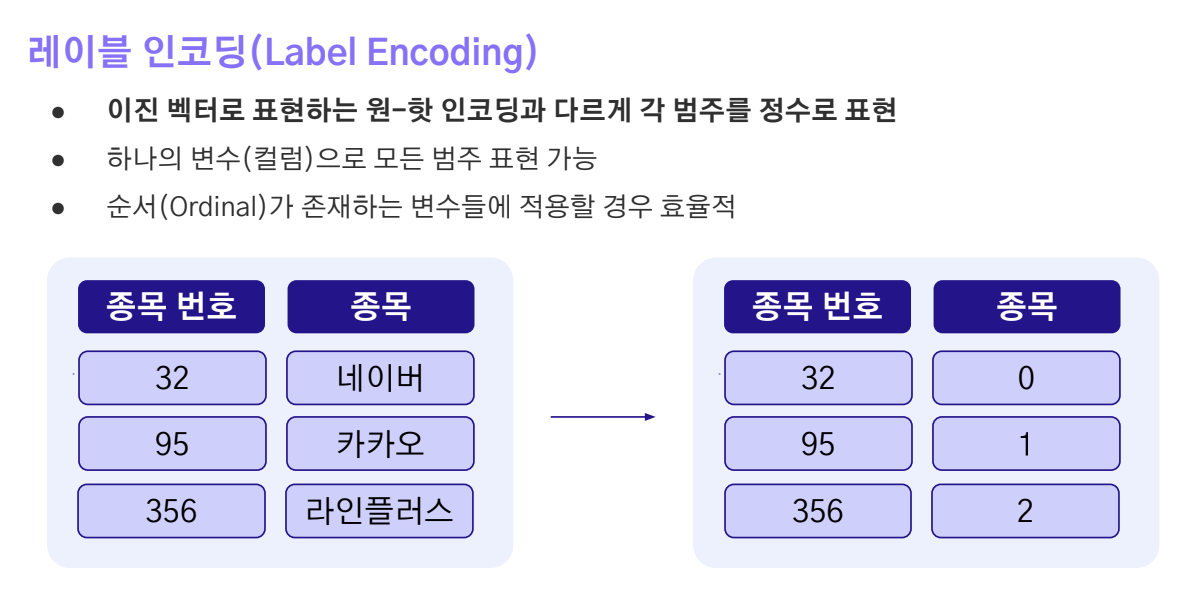

In [6]:
# 파생변수 제작으로 추가된 변수들이 존재하기에, 다시한번 연속형과 범주형 칼럼을 분리해주겠습니다.
continuous_columns_v2 = []
categorical_columns_v2 = []

for column in dt_train.columns:
    if pd.api.types.is_numeric_dtype(dt_train[column]):
        continuous_columns_v2.append(column)
    else:
        categorical_columns_v2.append(column)

print("연속형 변수:", continuous_columns_v2)
print("범주형 변수:", categorical_columns_v2)

연속형 변수: ['전용면적', '계약일', '층', '건축년도', 'k-전체동수', 'k-전체세대수', 'k-연면적', 'k-주거전용면적', 'k-관리비부과면적', 'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', '건축면적', '주차대수', '좌표X', '좌표Y', 'target', '계약년', '계약월', '강남여부', '가격상승률', '동등급', '브랜드등급', '한강근접여부', '지하철거리', '기준금리', '신축여부']
범주형 변수: ['아파트명', '도로명', 'k-단지분류(아파트,주상복합등등)', 'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형', 'k-난방방식', 'k-건설사(시공사)', 'k-시행사', 'k-사용검사일-사용승인일', '경비비관리형태', '세대전기계약방법', '청소비관리형태', '기타/의무/임대/임의=1/2/3/4', '단지승인일', '관리비 업로드', '단지신청일', '구', '동', '평형대', '학군']


In [7]:
# 범주형 변수에 대한 보간
concat_select[categorical_columns_v2] = concat_select[categorical_columns_v2].fillna('NULL')

# 연속형 변수에 대한 보간 (선형 보간)
concat_select[continuous_columns_v2] = concat_select[continuous_columns_v2].interpolate(method='linear', axis=0)

In [8]:
# EDA에 앞서 결측치를 확인해보겠습니다.
concat_select.isnull().sum()

아파트명                      0
전용면적                      0
계약일                       0
층                         0
건축년도                      0
도로명                       0
k-단지분류(아파트,주상복합등등)        0
k-세대타입(분양형태)              0
k-관리방식                    0
k-복도유형                    0
k-난방방식                    0
k-전체동수                    0
k-전체세대수                   0
k-건설사(시공사)                0
k-시행사                     0
k-사용검사일-사용승인일             0
k-연면적                     0
k-주거전용면적                  0
k-관리비부과면적                 0
k-전용면적별세대현황(60㎡이하)        0
k-전용면적별세대현황(60㎡~85㎡이하)    0
k-85㎡~135㎡이하              0
경비비관리형태                   0
세대전기계약방법                  0
청소비관리형태                   0
건축면적                      0
주차대수                      0
기타/의무/임대/임의=1/2/3/4       0
단지승인일                     0
관리비 업로드                   0
좌표X                       0
좌표Y                       0
단지신청일                     0
target                    0
is_test                   0
구                   

In [9]:
# 각 변수에 대한 LabelEncoder를 저장할 딕셔너리
label_encoders = {}

# 범주형 변수에 대해 레이블 인코딩을 적용
for col in tqdm(categorical_columns_v2):
    lbl = LabelEncoder()

    # 학습 데이터와 테스트 데이터를 모두 문자열로 변환하여 처리
    dt_train[col] = dt_train[col].astype(str)
    dt_test[col] = dt_test[col].astype(str)
    
    # 학습 데이터에 대한 레이블 인코딩을 학습 및 변환
    lbl.fit(dt_train[col])
    dt_train[col] = lbl.transform(dt_train[col])
    label_encoders[col] = lbl  # 나중에 후처리를 위해 레이블 인코더 저장
    
    # Test 데이터에서 학습에 없었던 레이블을 추가하는 방식
    unseen_labels = np.setdiff1d(np.unique(dt_test[col]), lbl.classes_)
    
    # 새로운 레이블이 있으면 학습된 클래스에 추가
    if unseen_labels.size > 0:
        new_classes = np.concatenate([lbl.classes_, unseen_labels])
        lbl.classes_ = new_classes
    
    # Test 데이터에 변환을 적용
    dt_test[col] = lbl.transform(dt_test[col])


100%|██████████| 21/21 [00:05<00:00,  3.64it/s]


### 5.2. Model Training
- 위 데이터를 이용해 모델을 train 해보겠습니다. 모델은 XGBoost 이용하겠습니다.
- 마크다운에 RandomForest관련 사항은 삭선표시해두었습니다.

In [10]:
assert dt_train.shape[1] == dt_test.shape[1]          # train/test dataset의 shape이 같은지 확인해주겠습니다.

In [23]:
# Target과 독립변수들을 분리해줍니다.
y_train = dt_train['target']
X_train = dt_train.drop(['target'], axis=1)

# Hold out split을 사용해 학습 데이터와 검증 데이터를 8:2 비율로 나누겠습니다.
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=2023)

In [24]:
import lightgbm as lgb

X_train.columns = X_train.columns.str.replace('[^A-Za-z0-9_]', '_', regex=True)
X_val.columns = X_val.columns.str.replace('[^A-Za-z0-9_]', '_', regex=True)

X_train.columns = X_train.columns.str.encode('ascii', 'ignore').str.decode('ascii')
X_val.columns = X_val.columns.str.encode('ascii', 'ignore').str.decode('ascii')

# LightGBM Dataset 준비
train_data = lgb.Dataset(X_train, label=y_train)
val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

In [26]:
# 중복된 열 이름 확인
print(X_train.columns[X_train.columns.duplicated()])
print(X_val.columns[X_val.columns.duplicated()])


Index(['____', '____', '___', 'k_____', 'k_____', 'k_____', 'k____', '_______',
       '____', '____', '_______', '_____', '_', '_', '___', '___', '____',
       '___', '_____', '___', '_____', '_____', '____', '____'],
      dtype='object')
Index(['____', '____', '___', 'k_____', 'k_____', 'k_____', 'k____', '_______',
       '____', '____', '_______', '_____', '_', '_', '___', '___', '____',
       '___', '_____', '___', '_____', '_____', '____', '____'],
      dtype='object')


In [25]:
# 파라미터 설정
params = {
    'objective': 'regression',  # 회귀 문제
    'metric': 'rmse',           # 평가 지표로 RMSE 사용
    'boosting_type': 'gbdt',    # GBDT 방식 사용
    'num_leaves': 31,           # 트리의 최대 잎 수
    'learning_rate': 0.05,      # 학습률
    'feature_fraction': 0.9,    # 피처 샘플링 비율
    'bagging_fraction': 0.8,    # 샘플링 비율
    'bagging_freq': 5,          # 배깅 빈도
    'verbose': -1               # 로그 출력 최소화
}


# 모델 훈련
from lightgbm import early_stopping

num_round = 100  # 학습할 최대 반복 횟수
model = lgb.train(params, train_data, num_round, valid_sets=[val_data], callbacks=[early_stopping(stopping_rounds=50)])


[LightGBM] [Fatal] Feature (____) appears more than one time.


LightGBMError: Feature (____) appears more than one time.